In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split

import seaborn as sns
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import scipy.ndimage
from tqdm import tqdm

print("FIN")

FIN


In [31]:
train = pd.read_csv("/kaggle/input/facial-keypoints-detection/training.zip")
test  = pd.read_csv("/kaggle/input/facial-keypoints-detection/test.zip")
IdL   = pd.read_csv("/kaggle/input/facial-keypoints-detection/IdLookupTable.csv")
samp  = pd.read_csv("/kaggle/input/facial-keypoints-detection/SampleSubmission.csv")

In [5]:
print(train.columns)
print(train.head)

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
<bound method NDFrame.head of       left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0       



**train_dfのimageの画像化**

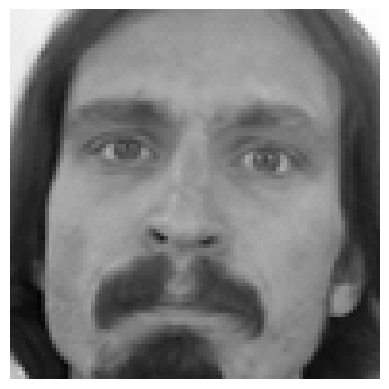

In [6]:
import ast
image_size=96
first_image_data=train["Image"].iloc[0]
# スペースで区切られている場合、カンマに変換
first_image_data = first_image_data.strip()  # 先頭と末尾の空白を削除
first_image_data = first_image_data.replace(' ', ',')  # スペースをカンマに置き換え

# 文字列をリストに変換
first_image_data = list(map(int, first_image_data.split(',')))  # 数値のリストに変換


# ピクセルデータを96x96の配列に変換
image_array = np.array(first_image_data).reshape(96, 96)

# 画像を表示
plt.imshow(image_array, cmap='gray')  # グレースケールで表示
plt.axis('off')  # 軸を非表示にする
plt.show()

学習てすと（fflill）

In [7]:
x_train=np.empty((7049,96,96,1))
x_test=np.empty((1783,96,96,1))

# 画像形式に変換
for i in range(7049):
    train0=train["Image"][i].split(" ")     #i番目の画像配列をスペース区切りで抽出
    train1=[int(x) for x in train0]         #それぞれをint型に直してリストへ格納
    train2=np.array(train1,dtype="float")   #リストをnumpy配列へ変換
    train3=train2.reshape(96,96,1)          #配列を96×96×1へ成形
    x_train[i]=train3                       #空のnumpy配列のi番目の要素として代入

for i in range(1783):
    test0=test["Image"][i].split(" ")
    test1=[int(x) for x in test0]
    test2=np.array(test1,dtype="float")
    test3=test2.reshape(96,96,1)    
    x_test[i]=test3
    
  

In [8]:
#正則化
#x_trainの画像データは0～255までの数値データになっている
x_train =x_train / 255
x_test = x_test /255  

#trainからimage列を取り出しy_trainに出力
y_train=train.drop(['Image'],axis=1)

# 前方埋めを行う
y_train_filled = y_train.ffill()

# 正規化
# y_trainの数値データは96x96のピクセルで管理されている
y_train_filled/=96

# true or　flaseのリスト
y_train_nan = y_train.isnull()


In [9]:
# クラス定義
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # 畳み込み層1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) # output_size = (96-3)/1+1=94
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output_size = 94/2=47
        
        # 畳み込み層2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)# output_size = (47-3)/1+1=45
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)# output_size = 45/22
        
        # 畳み込み層3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)# output_size = (22-3)/1+1=20
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)# output_size = 20/2=10
        
        # Dropout 層を追加（ドロップアウト率 0.5）
        self.dropout = nn.Dropout(p=0.5)
        
        # 全結合層
        self.fc1 = nn.Linear(128 * 10 * 10, 500)  # 畳み込み後の画像サイズを計算 (128, 10, 10)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 30)
    
    def forward(self, x):
        # 畳み込み層と活性化関数とプーリング
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        # フラット化
        x = x.view(-1, 128 * 10 * 10)  # Flatten the tensor
        
        # 全結合層と活性化関数 + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropoutを適用
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropoutを適用
        
        x = self.fc3(x)  # 最後の層では出力層に活性化関数を適用しない
        
        return x        

In [10]:
# もし x_train と y_train_filled が NumPy 配列やリストの場合、それをテンソルに変換
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test  = torch.tensor(x_test, dtype=torch.float32)
y_train_filled = torch.tensor(np.array(y_train_filled), dtype=torch.float32)
y_train_nan = torch.tensor(np.array(y_train_nan), dtype=torch.float32)
# (7049, 96, 96, 1) -> (7049, 1, 96, 96) に変換
x_train = x_train.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)

# データを8:2に分割する
x_train_split, x_val_split, y_train_split, y_val_split, _, nan_val = train_test_split(
    x_train, y_train_filled,y_train_nan, test_size=0.2, random_state=42
)

In [11]:
# データセットとデータローダーの作成
train_dataset = TensorDataset(x_train_split, y_train_split)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader   = DataLoader(x_test, batch_size=1, shuffle=False)

val_loader    = DataLoader(TensorDataset(x_val_split, y_val_split,nan_val), batch_size=1, shuffle=False)

In [12]:
# モデルを作成
model=CNNModel()

# 損失関数と最適化アルゴリズム
criterion = nn.MSELoss()  # 平均二乗誤差損失関数
optimizer = optim.Adam(model.parameters(), lr=0.001)

# アーリーストッピングの設定
early_stopping_patience = 5  # 5エポック改善がなければストップ
min_val_loss = np.inf
epochs_no_improve = 0

# 学習曲線を描くためのリスト
train_losses = []
val_losses = []  # バリデーション損失を記録するリスト

epoch_cnt=10
for epoch in range(epoch_cnt):
    model.train()  # 学習モードに設定
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()  # 勾配の初期化
        
        # 順伝播        
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # outoutsの誤植を修正
        
        # 逆伝播
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # エポックごとの平均損失を記録
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # バリデーションデータでの評価
    model.eval()  # 評価モード
    val_running_loss = 0.0
    
    with torch.no_grad():  # 勾配計算を無効にする
        for inputs, targets, nan_ in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item()
    
    val_epoch_loss = val_running_loss / len(val_loader)  # バリデーションの平均損失
    val_losses.append(val_epoch_loss)
    
    # 学習の進行状況を表示
    print(f'Epoch [{epoch+1}/{epoch_cnt}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
    
    
    # アーリーストッピングの判定
    if val_epoch_loss < min_val_loss:
        min_val_loss = val_epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == early_stopping_patience:
        print("Early stopping")
        break
print("FIN")
        

Epoch [1/10], Train Loss: 0.0129, Val Loss: 0.0013
Epoch [2/10], Train Loss: 0.0032, Val Loss: 0.0010
Epoch [3/10], Train Loss: 0.0022, Val Loss: 0.0010
Epoch [4/10], Train Loss: 0.0020, Val Loss: 0.0010
Epoch [5/10], Train Loss: 0.0019, Val Loss: 0.0011
Epoch [6/10], Train Loss: 0.0017, Val Loss: 0.0009
Epoch [7/10], Train Loss: 0.0016, Val Loss: 0.0009
Epoch [8/10], Train Loss: 0.0016, Val Loss: 0.0009
Epoch [9/10], Train Loss: 0.0015, Val Loss: 0.0009
Epoch [10/10], Train Loss: 0.0014, Val Loss: 0.0008
FIN


In [13]:
def view_(index, input_, target_, output_, nan_):
    print(nan_.numpy()[0].sum()>0)
    print(nan_.numpy()[0])
    # 最大損失のデータを取得
    ans_coords       = target_[0].numpy()*96
    predicted_coords = output_[0].numpy()*96

    # プロットのために特徴点のx, y座標を分割
    x_coords = predicted_coords[0::2]  # x座標
    y_coords = predicted_coords[1::2]  # y座標
    x_ans_coords = ans_coords[0::2]  # x座標
    y_ans_coords = ans_coords[1::2]  # y座標

    # 可視化
    # 入力データの一つを表示 (ここでは画像データを想定)
    plt.imshow(input_[0].cpu().numpy().transpose(1, 2, 0))  # 入力データの形状に応じて適宜変更
    plt.title(f'ind: {index}')
    plt.axis('off')
    plt.scatter(x_coords, y_coords, color='red', s=20,label="pred")  # 特徴点を赤い点で表示
    plt.scatter(x_ans_coords, y_ans_coords, color='blue', s=20,label="ans")  # 特徴点を赤い点で表示
    plt.legend()
    plt.show()

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


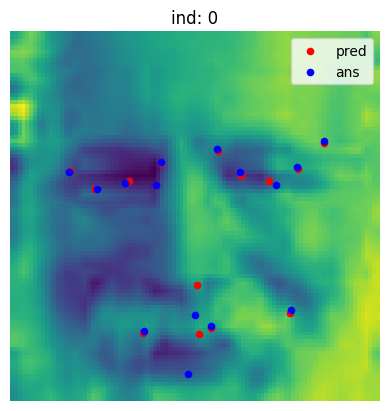

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


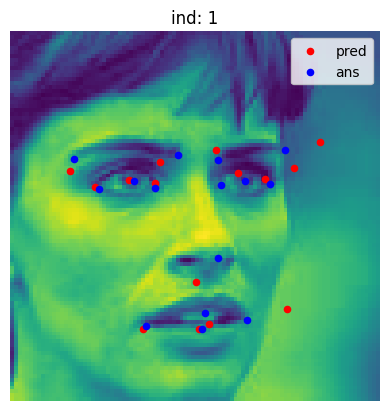

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


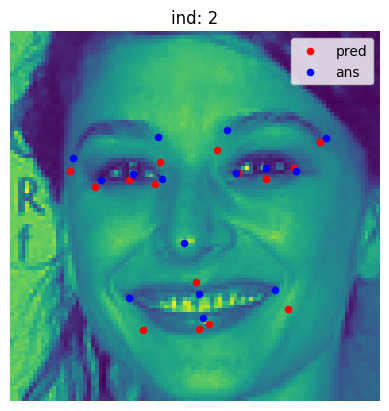

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


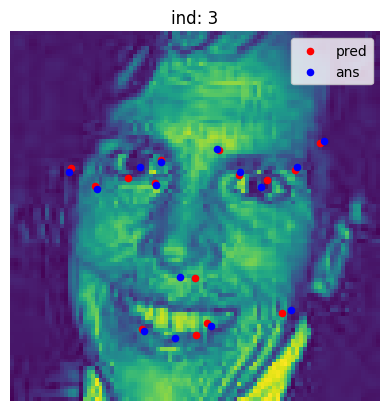

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


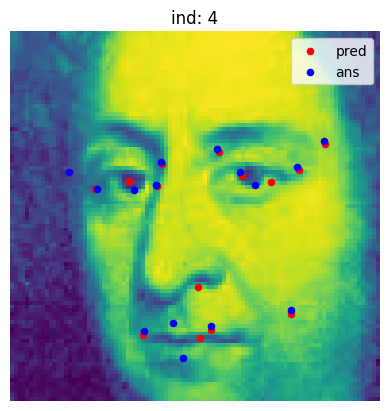

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


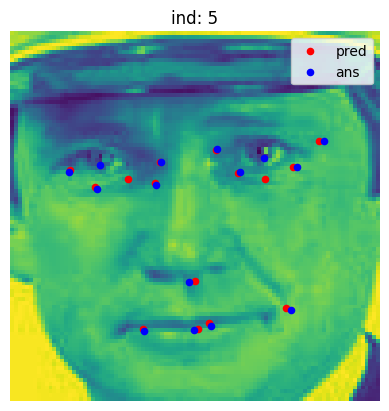

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


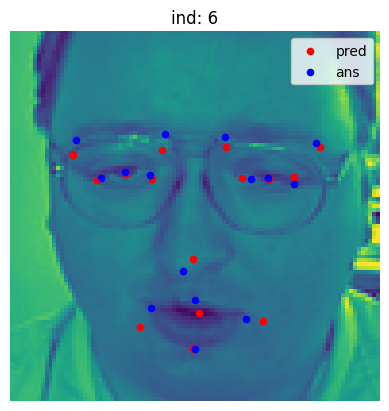

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


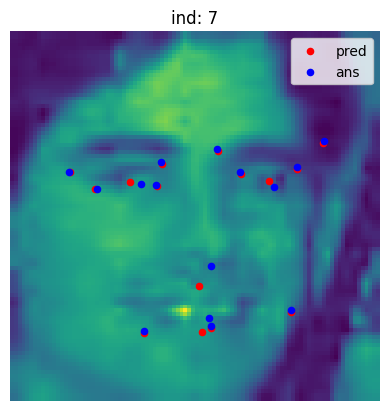

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


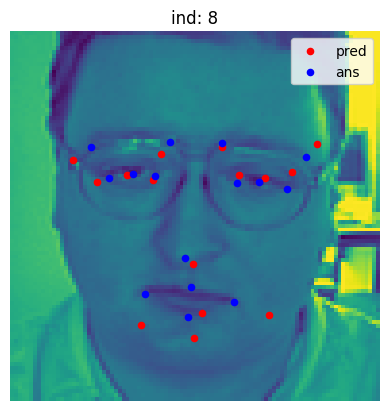

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


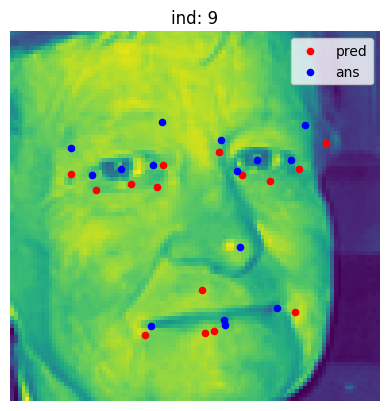

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


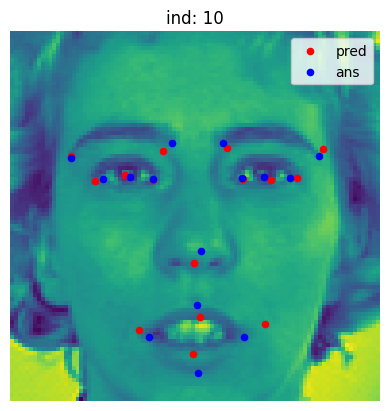

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


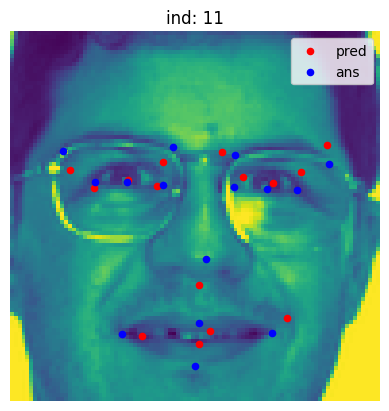

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


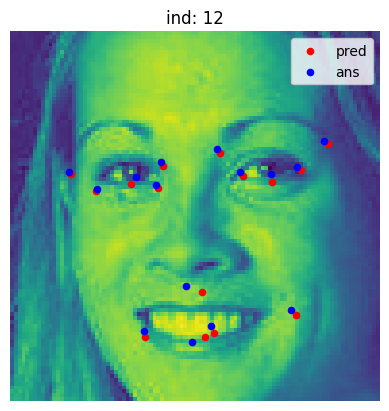

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


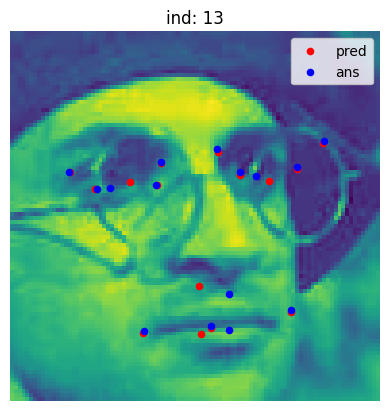

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


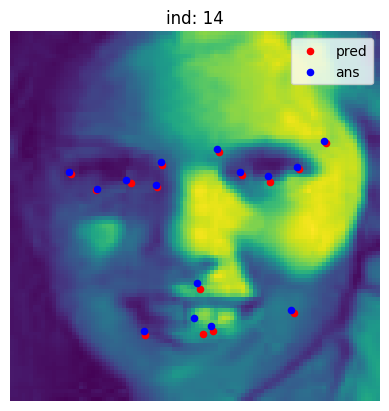

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


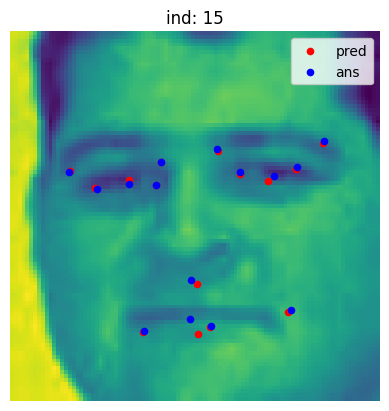

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


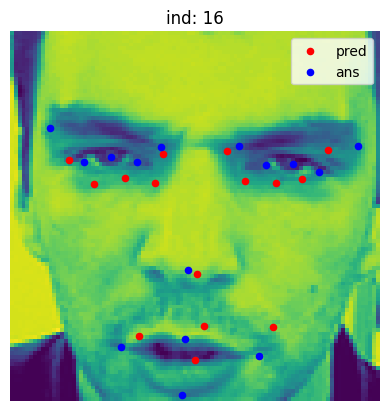

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


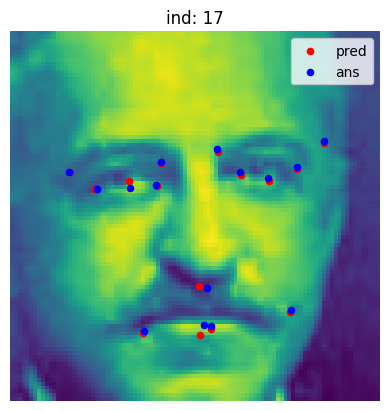

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


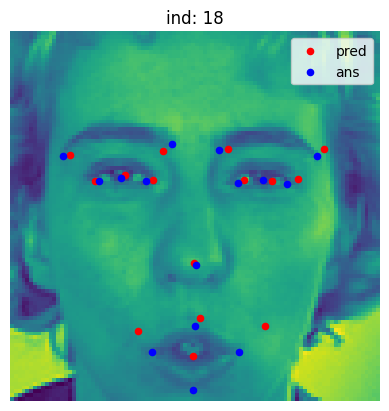

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


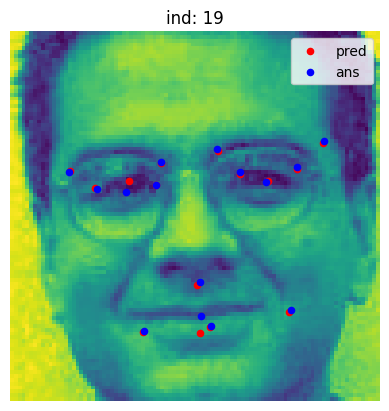

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


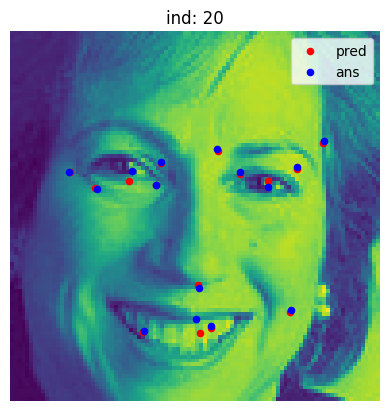

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


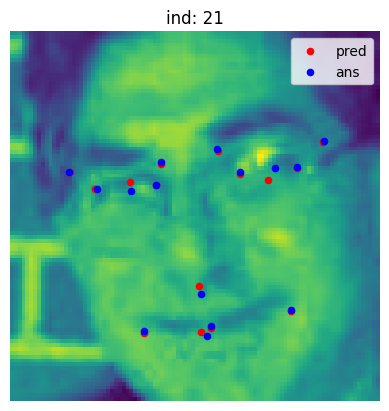

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


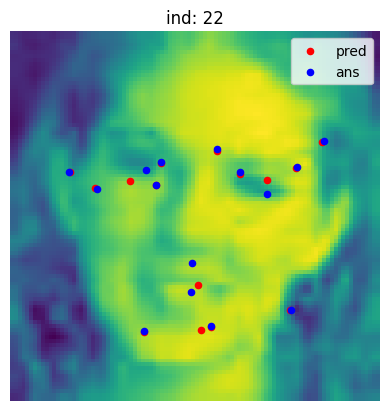

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


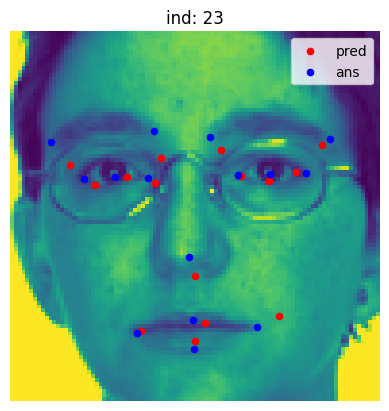

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


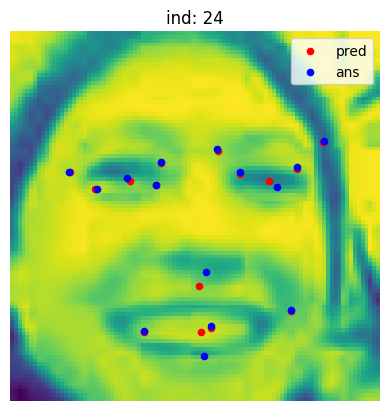

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


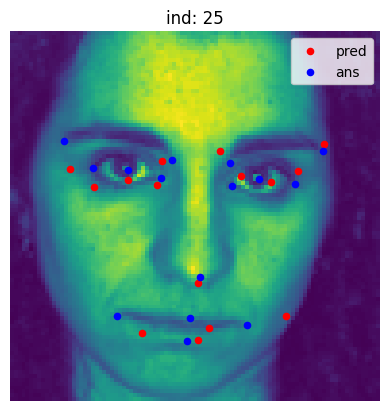

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


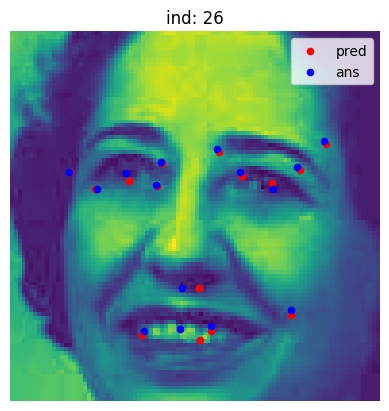

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


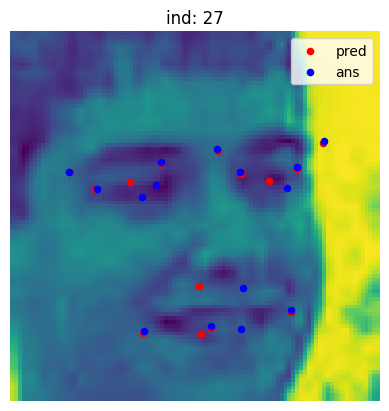

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


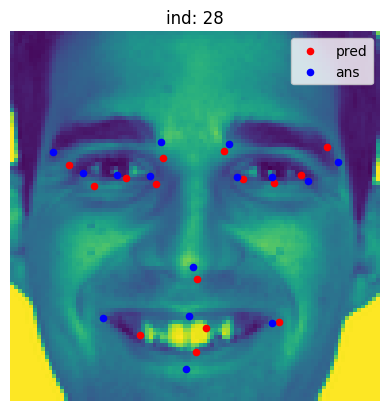

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


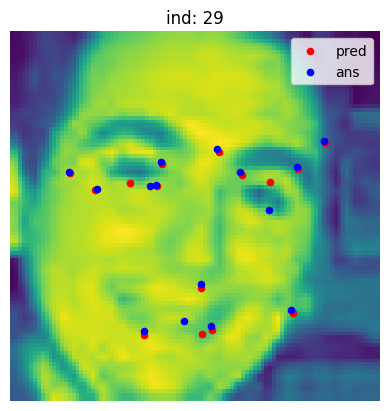

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


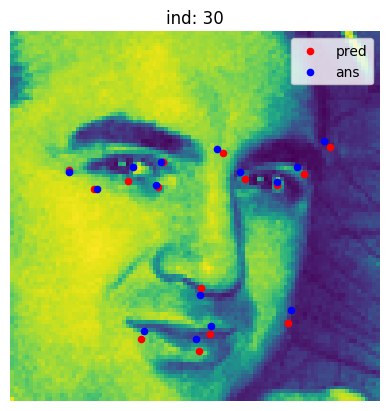

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


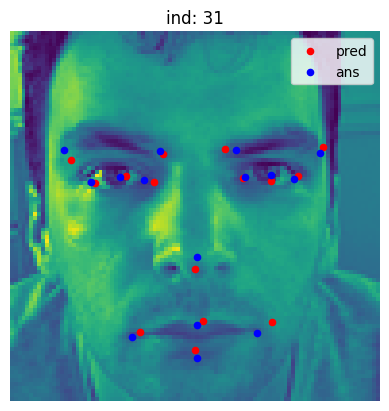

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


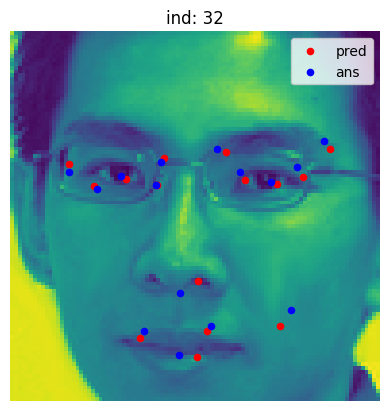

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


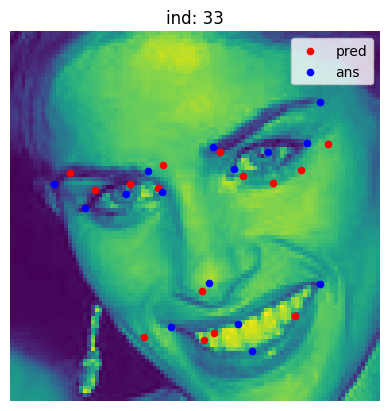

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


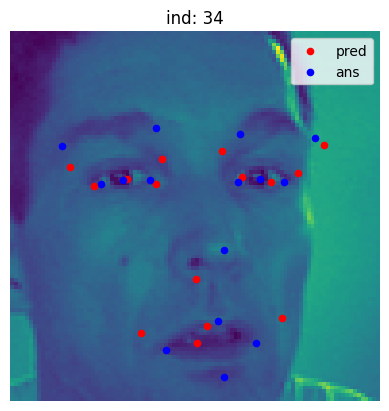

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


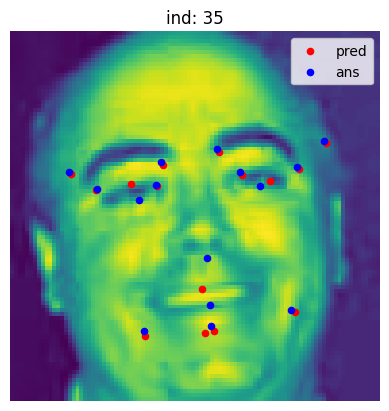

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


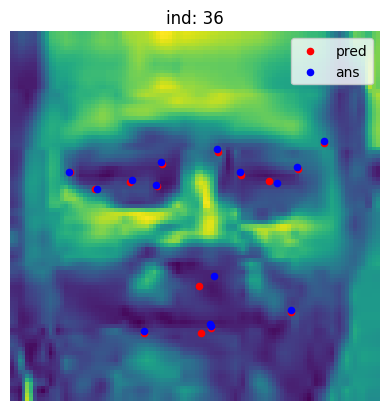

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


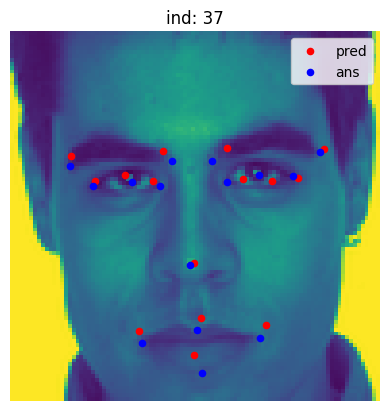

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


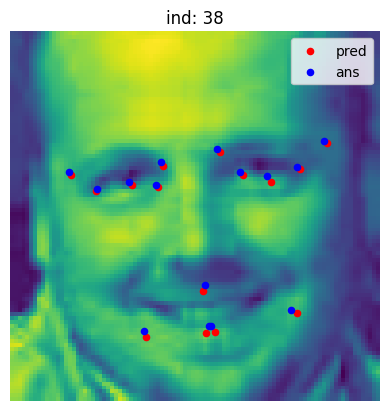

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


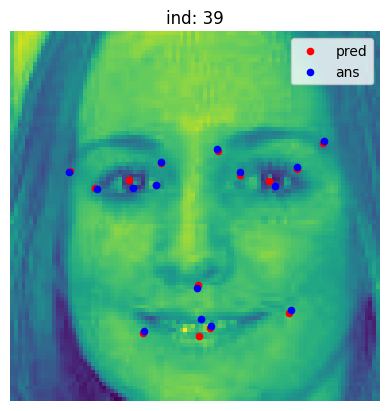

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


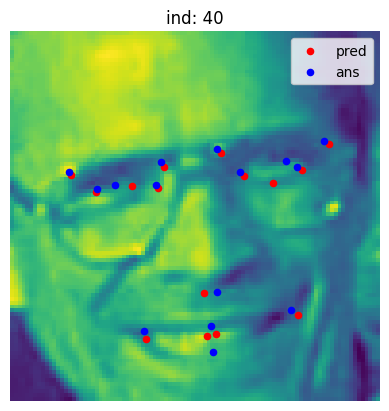

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


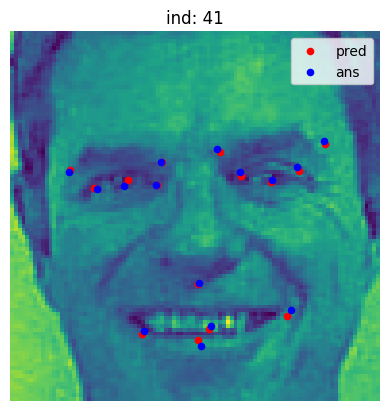

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


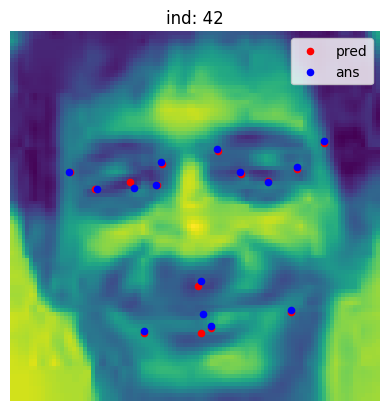

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


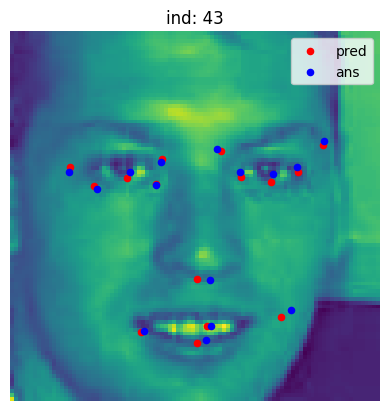

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


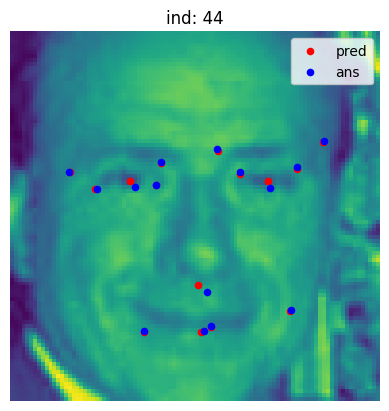

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


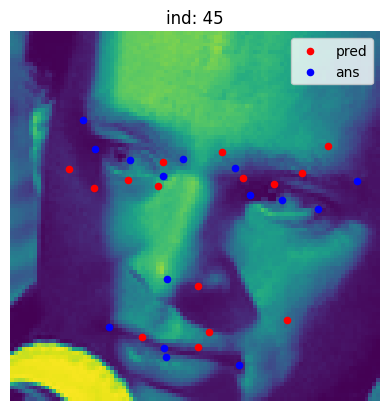

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


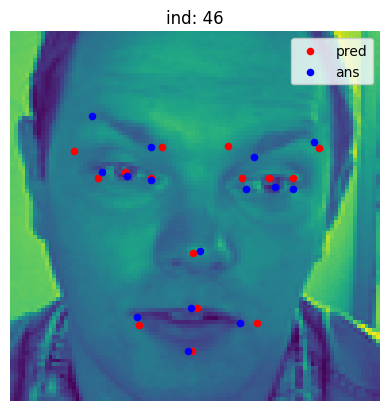

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


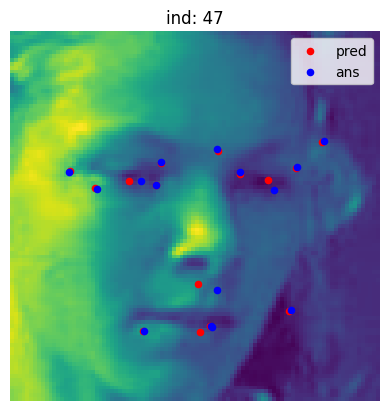

True
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0.]


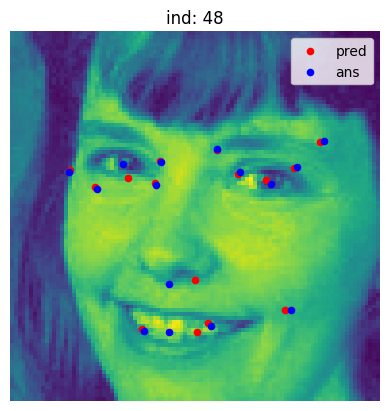

False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


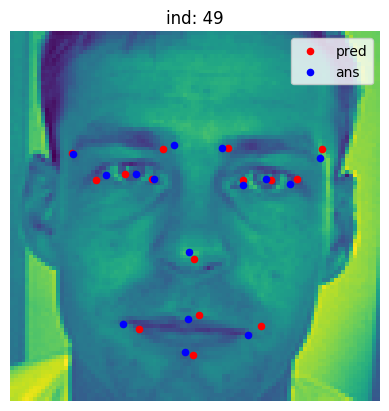

max_loss_index: 1250
True
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


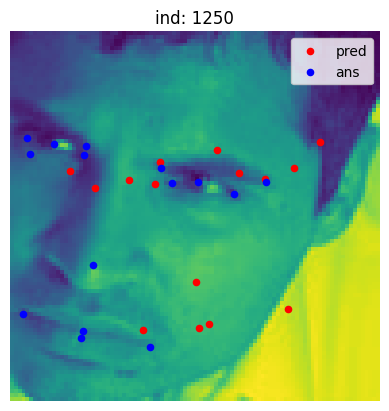

In [14]:
# モデルを評価モードに設定
model.eval()

# テストデータに対する予測と損失計算
test_losses  = []
test_outputs = []
test_targets = []
test_inputs  = []
test_nan     = []

with torch.no_grad():  # 勾配計算を無効にする
    for ind,(inputs, targets, nan_) in enumerate(val_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 損失をリストに追加
        test_losses.append(loss.item())
        test_outputs.append(outputs)
        test_targets.append(targets)
        test_inputs.append(inputs)
        test_nan.append(nan_)
        if ind<50:
            view_(ind, inputs, targets, outputs, nan_)

# 最大損失を持つデータのインデックスを取得
max_loss_index = np.argmax(test_losses)
print("max_loss_index:",max_loss_index)
view_(max_loss_index, 
      test_inputs[max_loss_index],
      test_targets[max_loss_index],
      test_outputs[max_loss_index],
      test_nan[max_loss_index]
     )

In [15]:
def check(input_, output_):
    predicted_coords = output_.numpy()*96
    # プロットのために特徴点のx, y座標を分割
    x_coords = predicted_coords[0][0::2]  # x座標
    y_coords = predicted_coords[0][1::2]  # y座標

    # 可視化
    # 入力データの一つを表示 (ここでは画像データを想定)
    plt.imshow(input_[0].cpu().numpy().transpose(1, 2, 0))  # 入力データの形状に応じて適宜変更
    #plt.title(f'error (Loss: {max_loss_value:.4f})')
    plt.axis('off')
    plt.scatter(x_coords, y_coords, color='red', s=20)  # 特徴点を赤い点で表示
    plt.show()    

In [16]:
# モデルを評価モードに切り替え
model.eval()

# 予測結果を保存するリスト
all_predictions = []

# テスト時は勾配を計算しないようにするため、torch.no_grad()を使う
with torch.no_grad():
    # テストデータをバッチごとにループ
    for i, inputs in enumerate(test_loader):
        # モデルに入力データを渡して予測を取得
        outputs = model(inputs)
        predictions=outputs
        # 0より小さい、または1より大きい値があるか検査
        if (outputs < 0).any() or (outputs > 1).any():
            print("error")
            check(inputs, outputs)
        # 予測結果をリストに追加
        all_predictions.append(predictions)

# 全てのバッチの予測結果を結合
all_predictions = torch.cat(all_predictions, dim=0)

# 予測結果を表示
print(all_predictions.shape)


torch.Size([1783, 30])


In [29]:
# predictionsはPyTorchのテンソルであるため、NumPy配列に変換
predictions_np = all_predictions.numpy()
y_labels=train.drop(['Image'],axis=1).columns

# PandasのDataFrameに変換し、列名を設定
predictions_df = pd.DataFrame(predictions_np, columns=y_labels)

predictions_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,0.697017,0.391844,0.307316,0.377335,0.624160,0.392903,0.764199,0.392249,0.378476,0.392198,...,0.491229,0.599504,0.667762,0.785865,0.344969,0.794240,0.503589,0.749734,0.488766,0.862492
1,0.702307,0.398852,0.308081,0.385513,0.625378,0.393963,0.772994,0.388611,0.384169,0.400351,...,0.495134,0.631559,0.696151,0.784792,0.345625,0.806125,0.513893,0.773929,0.493675,0.861315
2,0.692560,0.391698,0.311122,0.380850,0.619595,0.387806,0.760796,0.382990,0.381205,0.395035,...,0.493917,0.616521,0.687207,0.770949,0.349046,0.792333,0.511100,0.755771,0.492928,0.840249
3,0.693197,0.398692,0.315130,0.394984,0.616149,0.382356,0.768205,0.368092,0.389763,0.408132,...,0.499829,0.672168,0.741927,0.753799,0.353636,0.805157,0.532182,0.790405,0.502773,0.814419
4,0.698236,0.394248,0.306750,0.379877,0.624222,0.393432,0.766530,0.391305,0.379701,0.394461,...,0.491161,0.609303,0.675446,0.785858,0.344391,0.797815,0.505635,0.756907,0.489725,0.863208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,0.699146,0.401992,0.318017,0.400453,0.619957,0.383881,0.774713,0.368268,0.392633,0.412502,...,0.506199,0.686923,0.754955,0.756752,0.354577,0.812540,0.538839,0.801245,0.509733,0.818997
1779,0.691896,0.397425,0.320079,0.403769,0.618265,0.380470,0.770192,0.364973,0.391108,0.411156,...,0.506476,0.684514,0.758180,0.749444,0.358205,0.809990,0.540654,0.796535,0.514779,0.803695
1780,0.699301,0.401205,0.319927,0.404098,0.621504,0.383024,0.775325,0.367695,0.392812,0.414052,...,0.509439,0.690543,0.760526,0.755898,0.357166,0.815020,0.542158,0.803253,0.515232,0.815319
1781,0.699106,0.402082,0.317093,0.400917,0.621003,0.384258,0.776237,0.369237,0.392471,0.412976,...,0.503648,0.687013,0.754538,0.758897,0.354602,0.814038,0.538724,0.802540,0.508359,0.822067


In [32]:
# 結果を確認
print(IdL.isnull().sum())

# 'ImageID' と 'FeatureName' に基づいて、2次元表から値を取り出して 'Location' に格納
for idx, row in IdL.iterrows():
    image_id = row['ImageId']-1
    feature_name = row['FeatureName']
    
    # 2次元表(pivot_table)から、対応する 'ImageID' と 'FeatureName' の値を取得
    value = predictions_df.loc[image_id, feature_name]
    
    # 'Location' 列に値を格納
    IdL.at[idx, 'Location'] = value

RowId              0
ImageId            0
FeatureName        0
Location       27124
dtype: int64


In [35]:
# CSVファイルに出力（インデックスなし）

print(IdL)
#IdL=IdL.drop(['ImageId', 'FeatureName'], axis=1)
IdL["Location"] = IdL["Location"]*96
IdL.to_csv('submission_ffill_test.csv', index=False)

       RowId  Location
0          1  0.697017
1          2  0.391844
2          3  0.307316
3          4  0.377335
4          5  0.624160
...      ...       ...
27119  27120  0.395341
27120  27121  0.499339
27121  27122  0.673861
27122  27123  0.501635
27123  27124  0.825441

[27124 rows x 2 columns]
